In [1]:
from interpret import interpret
from querry import *
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from DataSet import DataSet

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

D:\Users\Huang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 8888

# create a new DataSet object
dataset = DataSet()
dataset.get_data('../data/TE_survey_csv_repaired.csv')

dataset.clean()
# drop data not being used in ANN
dataset.drop(['Authors', 'DOI', 'Comments', 'Comments.1', 'Author of Unit Cell','Unit Cell DOI'])

# use extrapolate_400K to extrapolate more row data
dataset_2 = DataSet()
dataset_2.data = dataset.extrapolate_400K([])
dataset_2.get_info()

1450 rows and 4 columns.
Components are: 
Formula, Resist, Seebeck, T (K)


In [3]:
# make an array containing the atomic descriptors
array = [compound_short_descriptors(x) for x in dataset_2.df['Formula'].values]
ndf = pd.DataFrame.from_records(array)
ndf = ndf.join(dataset_2.df[['T (K)']])

In [4]:
# clean up the data (get rid of strings and NaNs.)
ndf.apply(pd.to_numeric)
ndf = ndf.fillna(0)
print(ndf.head())

      0     1             2       3      4       5       6     7     8      9  \
0  1.00  16.0  3.400000e-08  3810.0  200.0  1757.0  1115.0  17.0  20.0  167.0   
1  1.00  16.0  3.400000e-08  3810.0  200.0  1757.0  1115.0  17.0  20.0  167.0   
2  1.00  16.0  3.400000e-08  3810.0  200.0  1757.0  1115.0  17.0  20.0  167.0   
3  1.00  16.0  3.400000e-08  3810.0  200.0  1757.0  1115.0  17.0  20.0  167.0   
4  0.98  16.0  3.400000e-08  3810.0  200.0  1757.0  1115.0  17.0  20.0  167.0   

    ...     71   72   73   74   75   76   77   78   79   T (K)  
0   ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   300.0  
1   ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   400.0  
2   ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   700.0  
3   ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1000.0  
4   ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   300.0  

[5 rows x 81 columns]


In [5]:
X = ndf.values
Y = dataset_2.df[['Seebeck']].values

In [6]:
X_train_pn, X_test_pn, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.10,
                                                    random_state=seed)

# create the scaler from the training data only and keep it for later use
X_train_scaler = StandardScaler().fit(X_train_pn)
# apply the scaler transform to the training data
X_train = X_train_scaler.transform(X_train_pn)
# tranform the testing set
X_test = X_train_scaler.transform(X_test_pn)

# # create the scaler from the training data only and keep it for later use
# y_train_scaler = StandardScaler().fit(y_train_pn)
# # apply the scaler transform to the training data
# y_train = y_train_scaler.transform(y_train_pn)
# # tranform the testing set
# y_test = y_train_scaler.transform(y_test_pn)

In [7]:
# define base model
def baseline_model():
    """
    Create an ANN model through Keras
    """
    # create model
    model = Sequential()
    model.add(Dense(81, input_dim=81, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, input_dim=100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [8]:
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs = 500, nb_epoch=1000, batch_size=100, verbose=2)

In [9]:
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Epoch 1/500
 - 1s - loss: 37166.9500
Epoch 2/500
 - 0s - loss: 37159.7254
Epoch 3/500
 - 0s - loss: 37145.8468
Epoch 4/500
 - 0s - loss: 37108.5808
Epoch 5/500
 - 0s - loss: 37031.8996
Epoch 6/500
 - 0s - loss: 36855.4682
Epoch 7/500
 - 0s - loss: 36509.9201
Epoch 8/500
 - 0s - loss: 35894.6201
Epoch 9/500
 - 0s - loss: 34896.5864
Epoch 10/500
 - 0s - loss: 33426.9636
Epoch 11/500
 - 0s - loss: 31615.0005
Epoch 12/500
 - 0s - loss: 29864.1123
Epoch 13/500
 - 0s - loss: 28414.1077
Epoch 14/500
 - 0s - loss: 27127.5759
Epoch 15/500
 - 0s - loss: 25845.3985
Epoch 16/500
 - 0s - loss: 24466.2117
Epoch 17/500
 - 0s - loss: 22946.6329
Epoch 18/500
 - 0s - loss: 21369.2678
Epoch 19/500
 - 0s - loss: 19748.0423
Epoch 20/500
 - 0s - loss: 18215.0188
Epoch 21/500
 - 0s - loss: 16811.6600
Epoch 22/500
 - 0s - loss: 15616.5893
Epoch 23/500
 - 0s - loss: 14707.4399
Epoch 24/500
 - 0s - loss: 14111.9295
Epoch 25/500
 - 0s - loss: 13446.1767
Epoch 26/500
 - 0s - loss: 12913.5322
Epoch 27/500
 - 0s - 

NOICE!!

# Go Deeper

In [10]:
# define the model
def larger_model():
    
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=81, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [11]:
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs = 500, nb_epoch=1000, batch_size=100, verbose=2)

In [12]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/500
 - 1s - loss: 37166.9485
Epoch 2/500
 - 0s - loss: 37159.6862
Epoch 3/500
 - 0s - loss: 37145.8051
Epoch 4/500
 - 0s - loss: 37108.4923
Epoch 5/500
 - 0s - loss: 37031.8576
Epoch 6/500
 - 0s - loss: 36855.4599
Epoch 7/500
 - 0s - loss: 36509.9090
Epoch 8/500
 - 0s - loss: 35893.3310
Epoch 9/500
 - 0s - loss: 34894.7205
Epoch 10/500
 - 0s - loss: 33424.0635
Epoch 11/500
 - 0s - loss: 31613.8576
Epoch 12/500
 - 0s - loss: 29860.6080
Epoch 13/500
 - 0s - loss: 28407.4983
Epoch 14/500
 - 0s - loss: 27126.6635
Epoch 15/500
 - 0s - loss: 25843.9740
Epoch 16/500
 - 0s - loss: 24457.3534
Epoch 17/500
 - 0s - loss: 22942.2970
Epoch 18/500
 - 0s - loss: 21368.7133
Epoch 19/500
 - 0s - loss: 19731.5077
Epoch 20/500
 - 0s - loss: 18193.7855
Epoch 21/500
 - 0s - loss: 16780.4716
Epoch 22/500
 - 0s - loss: 15578.1866
Epoch 23/500
 - 0s - loss: 14683.4561
Epoch 24/500
 - 0s - loss: 14030.5138
Epoch 25/500
 - 0s - loss: 13392.8183
Epoch 26/500
 - 0s - loss: 12846.7432
Epoch 27/500
 - 0s - 

Daaaang. That's pretty good!

# More Graphics

Epoch 1/20
 - 1s - loss: 37044.1836 - mean_squared_error: 37044.1836 - mean_absolute_error: 152.7559 - mean_absolute_percentage_error: 100.0089 - cosine_proximity: 0.1709
Epoch 2/20
 - 0s - loss: 37043.7617 - mean_squared_error: 37043.7617 - mean_absolute_error: 152.7548 - mean_absolute_percentage_error: 99.9195 - cosine_proximity: -2.4904e-01
Epoch 3/20
 - 0s - loss: 37043.3047 - mean_squared_error: 37043.3047 - mean_absolute_error: 152.7534 - mean_absolute_percentage_error: 99.8119 - cosine_proximity: -2.4904e-01
Epoch 4/20
 - 0s - loss: 37042.7266 - mean_squared_error: 37042.7266 - mean_absolute_error: 152.7519 - mean_absolute_percentage_error: 99.9351 - cosine_proximity: -2.4904e-01
Epoch 5/20
 - 0s - loss: 37041.9883 - mean_squared_error: 37041.9883 - mean_absolute_error: 152.7497 - mean_absolute_percentage_error: 100.1195 - cosine_proximity: -2.4904e-01
Epoch 6/20
 - 0s - loss: 37040.9922 - mean_squared_error: 37040.9922 - mean_absolute_error: 152.7469 - mean_absolute_percentage_

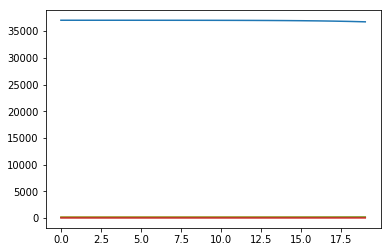

In [13]:
from matplotlib import pyplot

# create model
model = Sequential()
model.add(Dense(100, input_dim=81, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
# train model
history = model.fit(X_train, y_train, epochs=20, batch_size=len(X), verbose=2)
# plot metrics
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['mean_absolute_error'])
pyplot.plot(history.history['mean_absolute_percentage_error'])
pyplot.plot(history.history['cosine_proximity'])
pyplot.show()

In [14]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [15]:
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

Epoch 1/200
 - 3s - loss: 37044.1523 - rmse: 152.7559
Epoch 2/200
 - 0s - loss: 37043.9414 - rmse: 152.7553
Epoch 3/200
 - 0s - loss: 37043.5742 - rmse: 152.7542
Epoch 4/200
 - 0s - loss: 37042.8828 - rmse: 152.7522
Epoch 5/200
 - 0s - loss: 37041.2617 - rmse: 152.7479
Epoch 6/200
 - 0s - loss: 37037.2656 - rmse: 152.7373
Epoch 7/200
 - 0s - loss: 37027.3516 - rmse: 152.7110
Epoch 8/200
 - 0s - loss: 37002.9570 - rmse: 152.6464
Epoch 9/200
 - 0s - loss: 36943.8320 - rmse: 152.4898
Epoch 10/200
 - 0s - loss: 36805.2734 - rmse: 152.1214
Epoch 11/200
 - 0s - loss: 36484.8477 - rmse: 151.2631
Epoch 12/200
 - 0s - loss: 35774.6641 - rmse: 149.3213
Epoch 13/200
 - 0s - loss: 34217.3789 - rmse: 144.8538
Epoch 14/200
 - 0s - loss: 31107.8398 - rmse: 134.9928
Epoch 15/200
 - 0s - loss: 25953.6699 - rmse: 116.6023
Epoch 16/200
 - 0s - loss: 24941.5898 - rmse: 117.5742
Epoch 17/200
 - 0s - loss: 24593.3496 - rmse: 117.0792
Epoch 18/200
 - 0s - loss: 22610.5293 - rmse: 107.7302
Epoch 19/200
 - 0s 

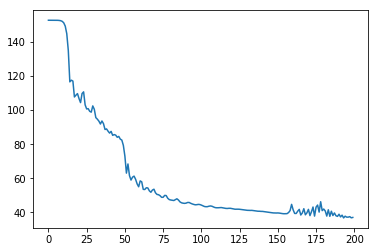

In [63]:
# create model
model.add(Dense(100, input_dim=81, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mse', optimizer='adam', metrics=[rmse])
# train model
history = model.fit(X_train, y_train, epochs=200, batch_size=1450, verbose=2)
# plot metrics
pyplot.plot(history.history['rmse'])
pyplot.show()

That is the RMSE metric.

In [17]:
np.concatenate((model.predict(X_test), y_test), axis=1)
#visual inspection on the testing sets.

array([[-253.65115356, -281.75      ],
       [-262.45834351, -358.019     ],
       [ 354.38327026,  325.374     ],
       [ -64.17979431,  -49.65      ],
       [-162.81596375, -228.446     ],
       [ 185.68876648,  151.36      ],
       [  24.5305233 ,   27.2882    ],
       [ -90.52802277, -124.72      ],
       [ 354.38040161,  403.782     ],
       [-112.54833221,  -81.62      ],
       [-145.22026062, -177.319     ],
       [ 176.73091125,  153.6       ],
       [ 323.28988647,  321.429     ],
       [ 116.96543884,   12.43      ],
       [-105.24344635,  -35.67      ],
       [  93.46622467,  142.661     ],
       [-134.13580322, -103.74      ],
       [  92.62108612,  149.997     ],
       [ 138.62742615,  239.        ],
       [-226.52255249, -287.        ],
       [ -75.56744385,  -72.01      ],
       [  26.79366302,   19.3       ],
       [-104.09664154, -119.99      ],
       [  87.43167114, -174.        ],
       [-185.93959045, -147.        ],
       [-104.55347443,  -

In [64]:
# just for testing, at the end.
def test_data(compound, T):
    """Converts one sample to raw data for predicting thru ANN"""
    array = np.zeros(80) # create an empty array with zeros
    descriptors = np.array(compound_short_descriptors(compound)) # load descriptors 
    for index, x in np.ndenumerate(descriptors):
        array[index] = x
    ndf = pd.DataFrame(data=array)
    # clean up the data (get rid of strings and NaNs.)
    ndf.apply(pd.to_numeric)
    ndf = ndf.fillna(0)
    ndf = ndf.append([T])
    array = X_train_scaler.fit_transform(ndf)
    array = array.T
    return array

def print_predict(compound, T):
    print(str(model.predict(test_data(compound, T))[0][0]) + '  (uV/K)')
    
def predict(compound, T):
    return (model.predict(test_data(compound, T))[0][0])
    
def three_elements_to_heat(s_1,s_2,s_3,c_1,c_2,c_3):
    """input 3 strs and 3 coefficients output the compound formula"""
    return s_1+str(c_1)+s_2+str(c_2)+s_3+str(c_3)

In [65]:
print_predict('Ca0.98La0.02MnO3', 300)

-91.414536

In [66]:
print_predict('CaMnO3', 500)

-121.263756  (uV/K)


In [67]:
print_predict('FeSb2Ge0.1Te0.9', 500)

136.79593  (uV/K)


In [68]:
print_predict('MnMnMn', 600)
print_predict('MnMn', 600)
print_predict('Mn', 600)

320.99252  (uV/K)
320.99252  (uV/K)
320.99252  (uV/K)


In [69]:
print_predict('MnTe', 400)
print_predict('MnTeMnTe', 400)
print_predict('CaMnTe', 400)

144.00163  (uV/K)
144.00163  (uV/K)
-138.74808  (uV/K)


Pretty smart!

COOL!
Gotta go to sleep. See you next time.

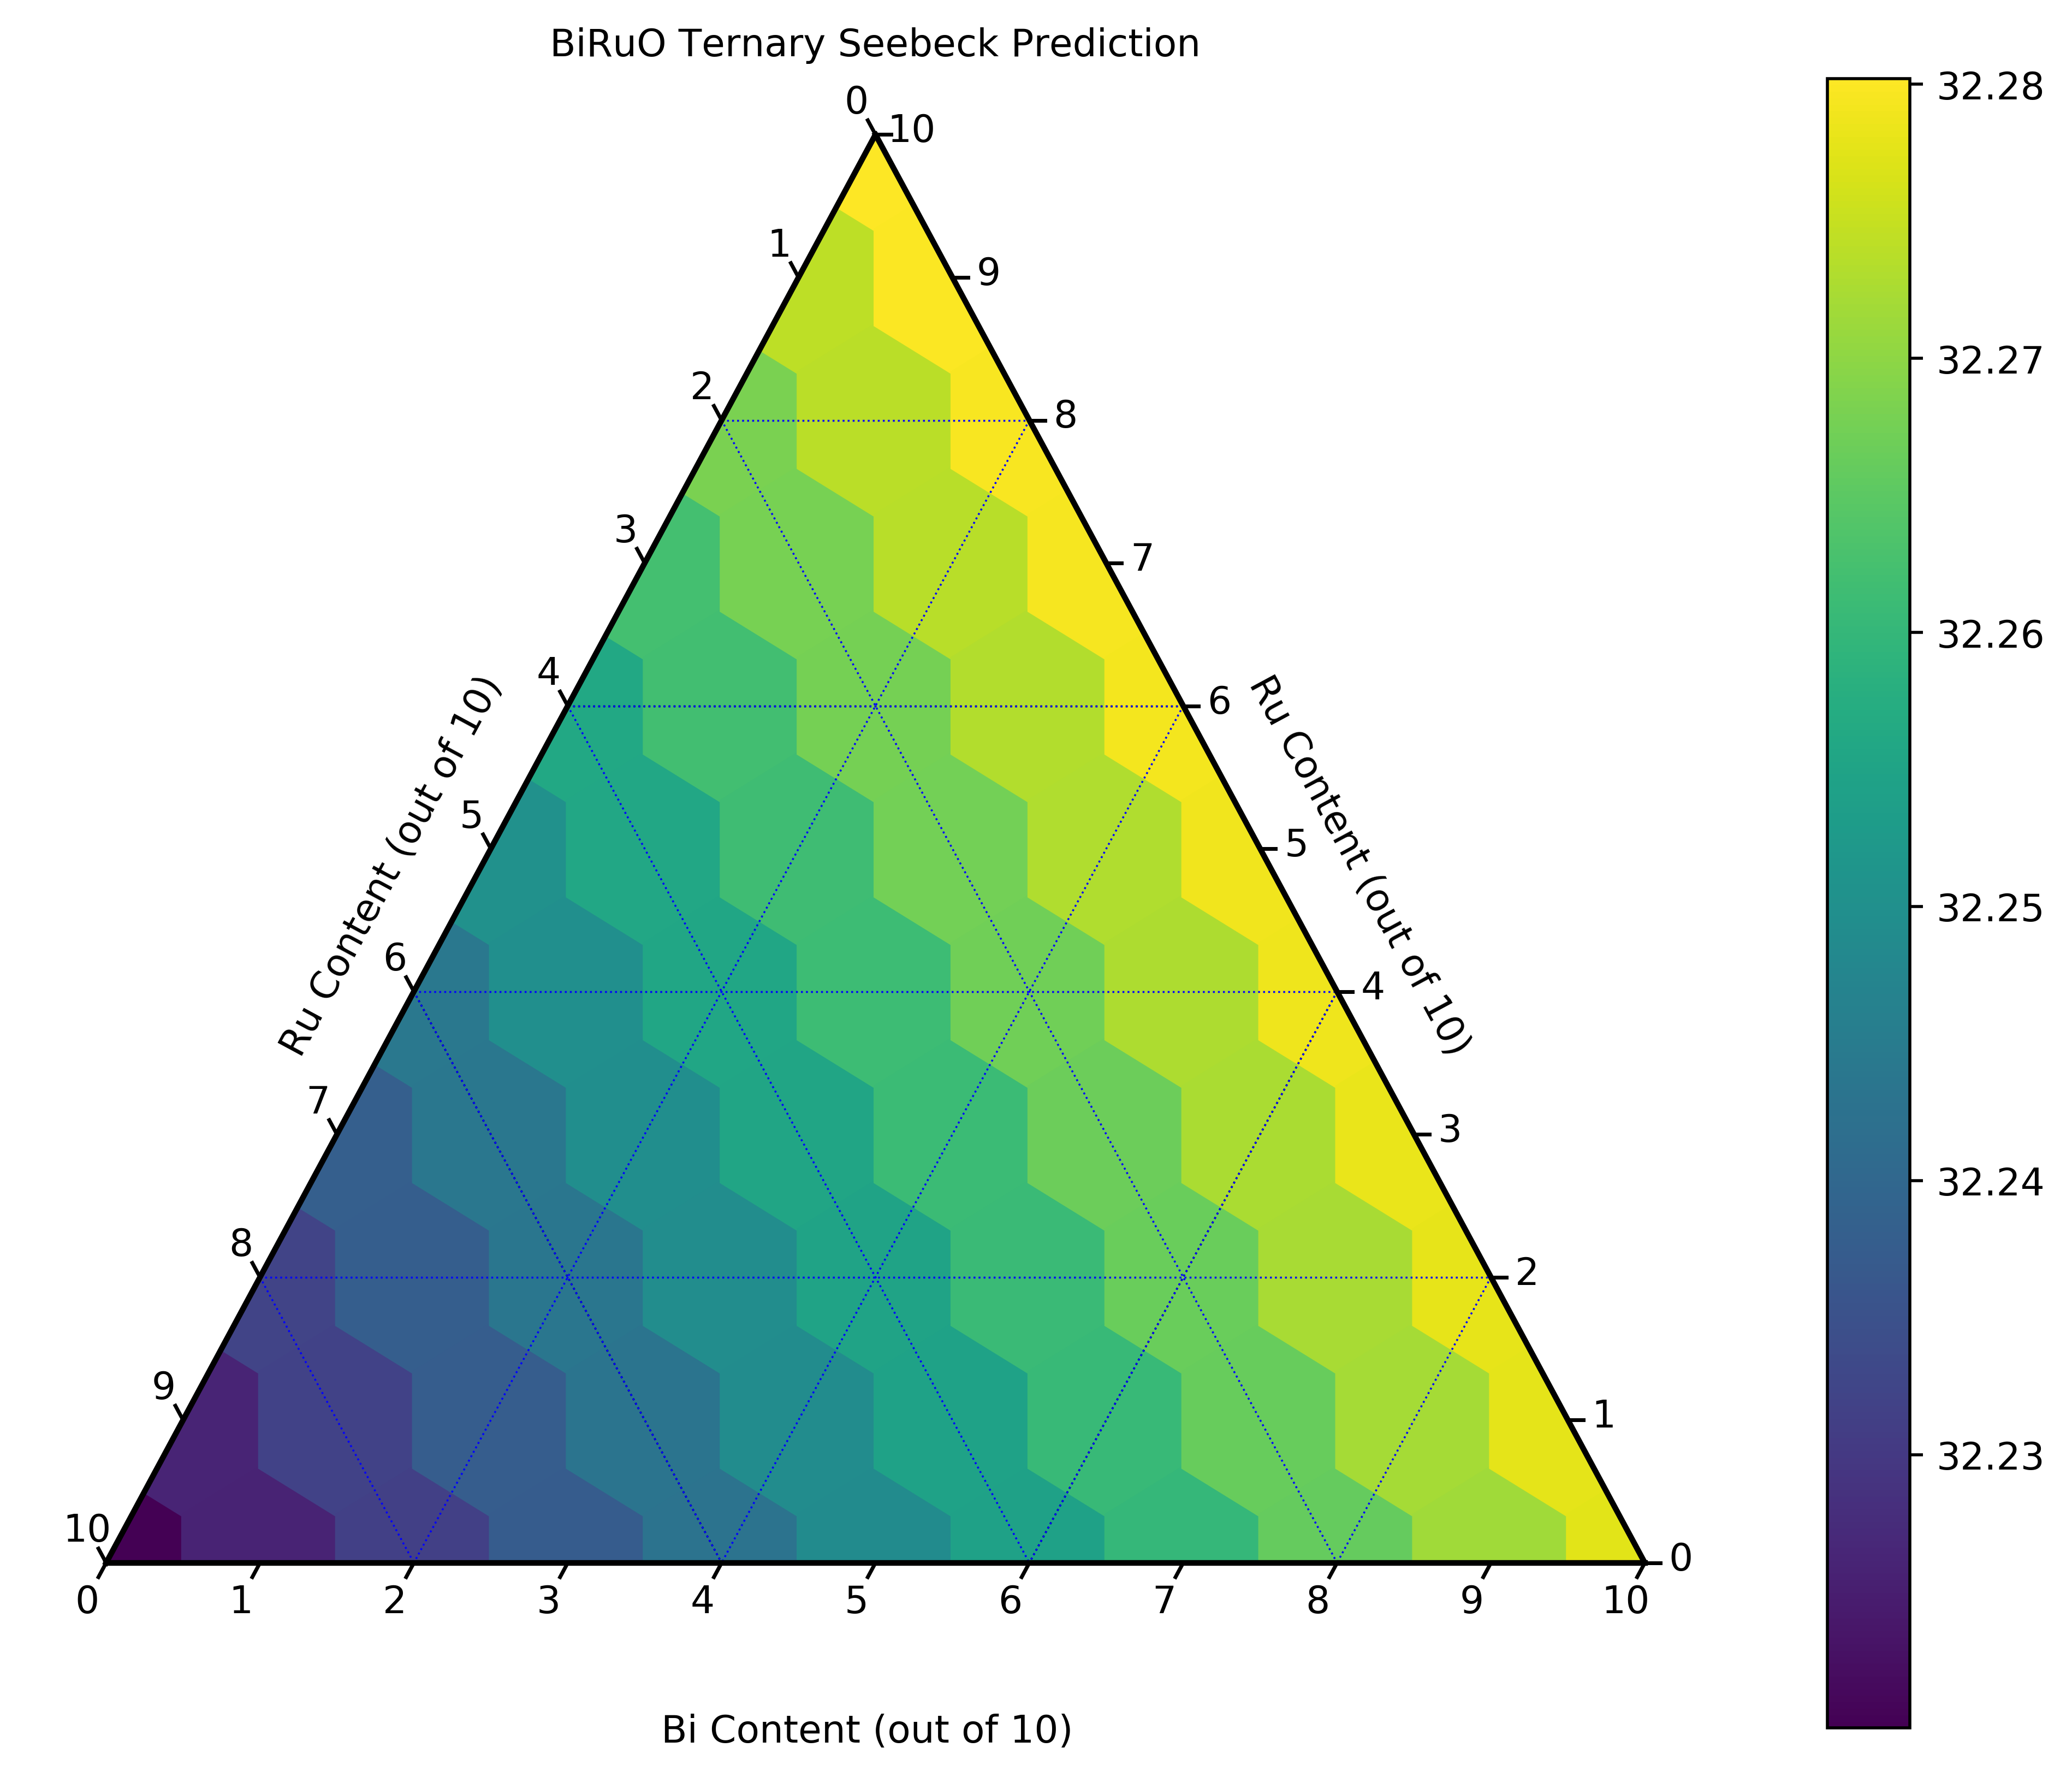

In [154]:
import math
import ternary

def generate_random_heatmap_data(s1, s2, s3, T=400, scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i,j,k) in simplex_iterator(scale):
        compound = three_elements_to_heat(s1, s2, s3, i, j, k)
        heat = predict(compound, T)
        d[(i,j)] = heat
    return d

scale = 10

s1 = 'Bi'
s2 = 'Ru'
s3 = 'O'
T = 400

## Boundary and Gridlines
fontsize = 10
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 8)
figure.set_dpi(500)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1.0)
tax.gridlines(color="black", multiple=6)
tax.gridlines(color="blue", multiple=2, linewidth=0.5)

# Set Axis labels and Title
tax.set_title("{}{}{} Ternary Seebeck Prediction".format(s1,s2,s3), fontsize=fontsize)
tax.left_axis_label("{} Content (out of 10)".format(s2), fontsize=fontsize)
tax.right_axis_label("{} Content (out of 10)".format(s2), fontsize=fontsize)
tax.bottom_axis_label("{} Content (out of 10)".format(s1), fontsize=fontsize, ha='center')

d = generate_random_heatmap_data(s1,s2,s3,T,scale)
# figure, tax = ternary.figure(scale=scale)
tax.heatmap(d, style="h")
tax.boundary()
tax.ticks(axis='lbr', linewidth=1, multiple=1)

tax.clear_matplotlib_ticks()
tax.ax.set_axis_off()
tax.show()

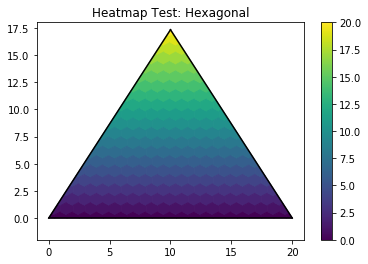

In [138]:

def generate_random_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i,j,k) in simplex_iterator(scale):
        d[(i,j)] = j
    return d

scale = 20
d = generate_random_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(d, style="h")
tax.boundary()
tax.set_title("Heatmap Test: Hexagonal")

tax.show()

No handles with labels found to put in legend.


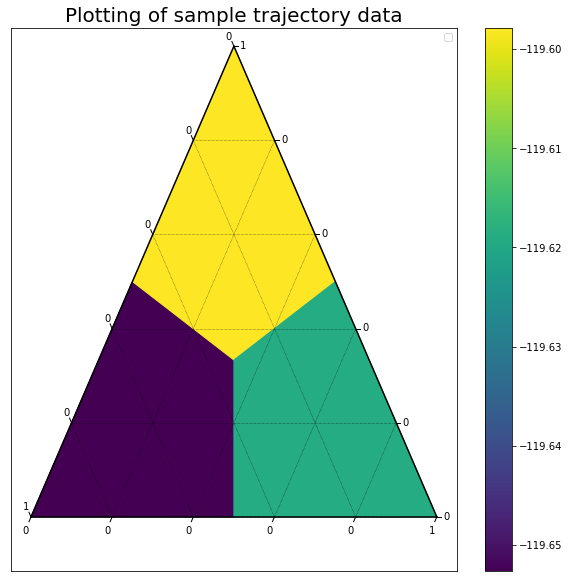

In [128]:
import math
import ternary

def heatmap_data(s1, s2, s3, T=400, scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i,j,k) in simplex_iterator(scale):
        compound = three_elements_to_heat(s1, s2, s3, i, j, k)
        heat = predict(compound, T)
        d[(i,j)] = heat
    return d

scale = 1

s1 = 'Ca'
s2 = 'Mn'
s3 = 'O'
T = 400

## Sample trajectory plot
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(10, 10)

tax.boundary()
tax.gridlines(multiple=0.2, color="black")
tax.set_title("Plotting of sample trajectory data", fontsize=20)
# Load some data, tuples (x,y,z)

d = heatmap_data(s1,s2,s3,T,scale)

# Plot the data
tax.heatmap(d, style="h")
tax.ticks(axis='lbr', multiple=0.2, linewidth=1)
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()